In [11]:
from PIL import Image
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import cv2
import json
import numpy as np


def create_kMeans_hsv_mask(img_arr):
    img_arr = img_arr[:, [1]]
    kmeans = KMeans(n_clusters = 2, random_state = 1).fit(img_arr)
    
    color_args = np.array(kmeans.labels_).astype(bool)
    
    if np.sum(color_args == 0) < np.sum(color_args == 1):
        color_args = np.invert(color_args)
    
    colors = np.array([0, 255]).astype(np.uint8)
    
    return colors[color_args.astype(np.uint8)]

def segment_objects(img):
    img_arr = np.array(img)
    x, y, z = img_arr.shape
    img_arr_flat = img_arr.reshape((x*y, z))
    mask = create_kMeans_hsv_mask(img_arr_flat)

    return mask.reshape((x, y))

def find_contours(img_bin, min_area=0, max_area=1000000, fill=True, external=True):
    mode = cv2.RETR_EXTERNAL
    if not external:
        mode = cv2.RETR_LIST
    contours, _  = cv2.findContours(img_bin, mode, cv2.CHAIN_APPROX_SIMPLE)
    contours =  [c for c in contours if cv2.contourArea(c) > min_area and cv2.contourArea(c) < max_area]
    thick = cv2.FILLED
    if not fill: thick = 2
    contour_drawn = cv2.drawContours(np.zeros(img_bin.shape, dtype=np.uint8), contours, -1, color=(255, 255, 255), thickness=thick)
    return contour_drawn, len(contours), contours  

def get_centers(contours):
    
    contour_centers = list()
    
    for contour in contours:
        M = cv2.moments(contour)
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        contour_centers.append((cX, cY))
    
    contour_centers.sort()

    return contour_centers

In [12]:
with open('image_5_RGB.json', 'r') as infile:
    img = json.load(infile)
width = img[1]
height = img[2]
image = np.array(img[0], dtype=np.uint8).reshape((height, width, 3))
image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
mask = segment_objects(image)
cont_img, cont_count, cont_arr = find_contours(mask, min_area=1000)
centers = get_centers(cont_arr)

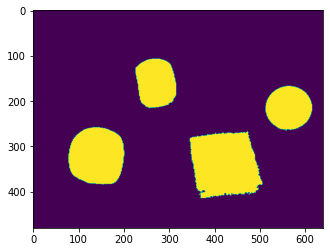

In [13]:
plt.imshow(cont_img)

In [14]:
centers

[(140, 321), (271, 160), (422, 339), (563, 215)]